# Length binned gradient boosting classifier

## 1. Run setup

In [1]:
# Change working directory to parent so we can import as we would from main.py
print(f'Working directory: ', end = '')
%cd ..

import pickle

from scipy.stats import uniform, randint
from sklearn.metrics import make_scorer

import configuration as config
import functions.notebook_helper as helper_funcs
import functions.notebook_plotting as plot_funcs
import functions.parallel_xgboost as xgb_funcs

Working directory: /mnt/arkk/llm_detector/classifier


Set some run parameters and decide whether to run or load data for each experiment:

In [2]:
# Number of folds to run for cross validation
cv_folds = 5
workers = 3
hyperparameter_iterations = 6

rerun_cross_validation = False
rerun_cross_validation_control = False
rerun_hyperparameter_optimization = False

cross_validation_results_filename = f'{config.DATA_PATH}/cross_validation_results_{cv_folds}_folds.pkl'
cross_validation_control_results_filename = f'{config.DATA_PATH}/cross_validation_control_results_{cv_folds}_folds.pkl'
hyperparameter_optimization_results_filename = f'{config.DATA_PATH}/hyperparameter_optimization_results_{hyperparameter_iterations}_iterations.pkl'

Get ready to read the input data:

In [3]:
# The dataset to train on - omit the file extension, it will be added
dataset_name = 'falcon-7b_scores_v2_10-300_words'

# Input file path
input_file = f'{config.DATA_PATH}/{dataset_name}.h5'

Let's also make a data structure to collect results for plotting as we go.

In [4]:
# Dictionary to hold testing/experimentation results
parsed_results = {
    'Fold': [],
    'Condition': [],
    'Optimized': [],
    'Accuracy (%)': [],
    'False positive rate': [],
    'False negative rate': [],
    'Binary cross-entropy': []
}

# Plots to draw
plots = ['Accuracy (%)', 'False positive rate', 'False negative rate', 'Binary cross-entropy']

Make a dictionary of scoring functions to be used as metrics:

In [5]:
# Make evaluation metrics scorers
scoring_funcs = {
    'binary_cross_entropy': make_scorer(helper_funcs.binary_cross_entropy), 
    'accuracy': make_scorer(helper_funcs.percent_accuracy),
    'false_positive_rate': make_scorer(helper_funcs.false_positive_rate),
    'false_negative_rate': make_scorer(helper_funcs.false_negative_rate)
}

## 2. Stage I classifiers: baseline performance
### 2.1. Cross-validation

Data loaded from previous run.


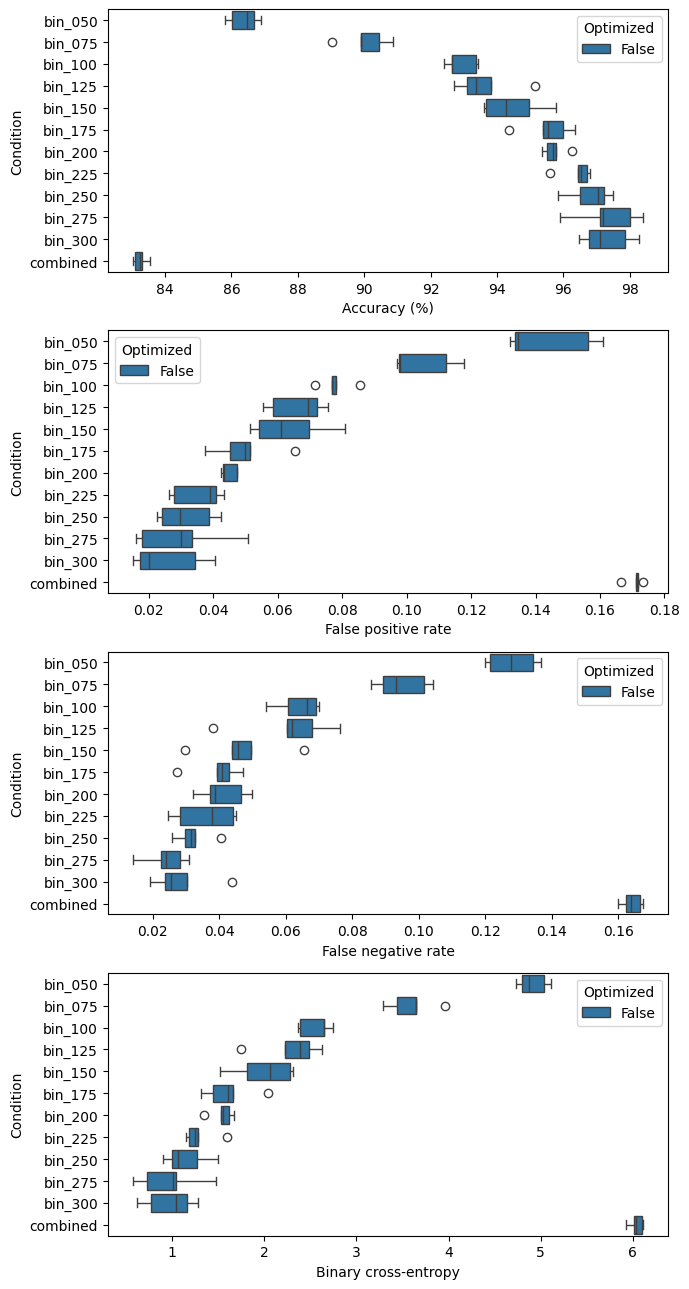

In [6]:
# Re-run the cross-validation only if asked
if rerun_cross_validation is True:

    # Do the cross-validation
    parsed_results = xgb_funcs.cross_validate_bins(
        input_file = input_file, 
        scoring_funcs = scoring_funcs, 
        parsed_results = parsed_results,
        cv_folds = cv_folds,
        workers = workers
    )

    # Save the result
    with open(cross_validation_results_filename, 'wb') as result_output_file:
        pickle.dump(parsed_results, result_output_file, protocol = pickle.HIGHEST_PROTOCOL)

# If we don't want to re-run it, load the old data
elif rerun_cross_validation is False:

    with open(cross_validation_results_filename, 'rb') as result_input_file:
        parsed_results = pickle.load(result_input_file)
        print(f'Data loaded from previous run.')

# Plot the results
plot_funcs.plot_two_factor_cross_validation(plots, parsed_results).show()

### 2.2. Cross-validation: shuffled control

Data loaded from previous run.


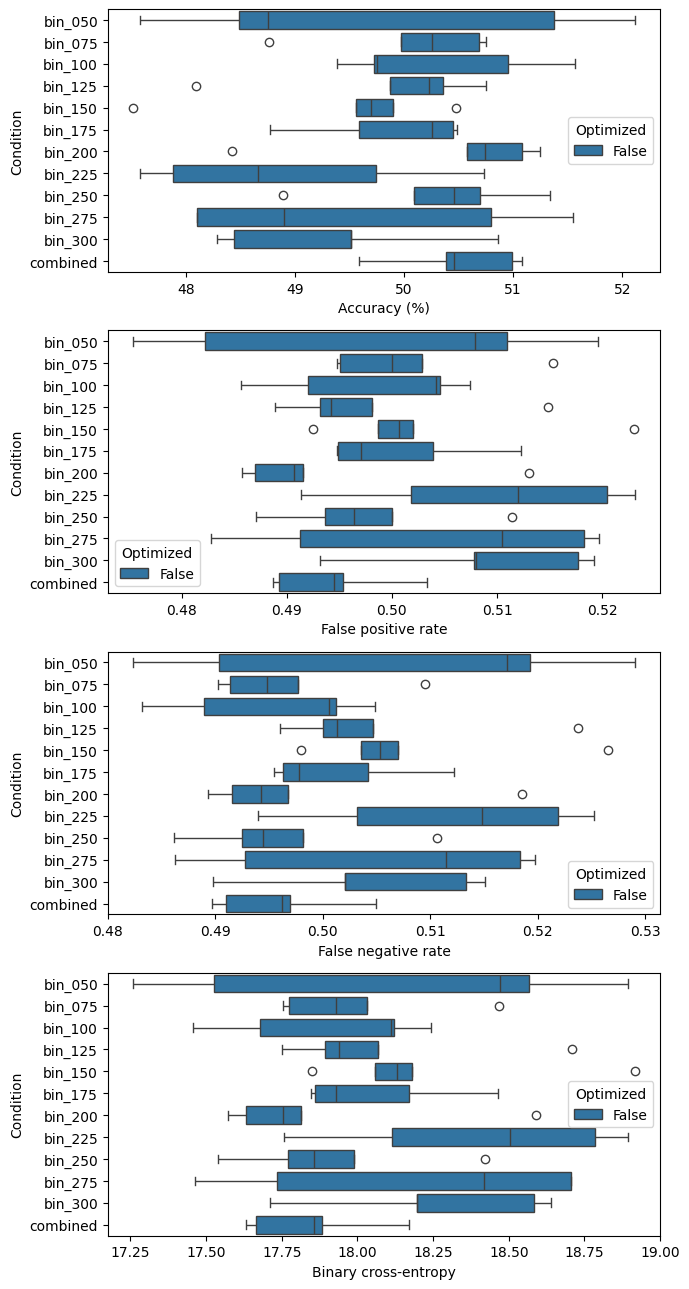

In [7]:
# Re-run the control cross-validation only if asked
if rerun_cross_validation_control is True:

    # Start a fresh results dictionary so we don't over-write our baseline results
    parsed_control_results = {
        'Fold': [],
        'Condition': [],
        'Optimized': [],
        'Accuracy (%)': [],
        'False positive rate': [],
        'False negative rate': [],
        'Binary cross-entropy': []
    }

    # Do the cross-validation
    parsed_control_results = xgb_funcs.cross_validate_bins(
        input_file = input_file, 
        scoring_funcs = scoring_funcs, 
        parsed_results = parsed_control_results,
        cv_folds = cv_folds,
        workers = workers, 
        shuffle_control = True
    )

    # Save the result
    with open(cross_validation_control_results_filename, 'wb') as result_output_file:
        pickle.dump(parsed_control_results, result_output_file, protocol = pickle.HIGHEST_PROTOCOL)

# If we don't want to re-run it, load the old data
elif rerun_cross_validation_control is False:

    with open(cross_validation_control_results_filename, 'rb') as result_input_file:
        parsed_control_results = pickle.load(result_input_file)
        print(f'Data loaded from previous run.')

# Plot the results
plot_funcs.plot_two_factor_cross_validation(plots, parsed_control_results).show()

OK, cool! That works great - the real classifier is definitely performing better than the shuffled control. Lots of things to say here, so I'll make a list:

1. The performance in the longer bins is impressive - we get to and well above 95% accuracy with no tuning or hyperparameter optimization at all.
2. Performance on short text fragments is not great in comparison. We don't get to 90% accuracy until bin 75 which contains fragments between 26 and 75 words. One of the things I know people would want to use this for is spotting bot posts on social media. But i'm starting to think content moderation is a totally different problem all together.
3. We may be leaving some accuracy on the table - remember, the bins overlap so each fragment is seen by two different classifiers. E.g. a 30 word fragment is scored by the classifiers for bins 50 and 75. Next step should probably be to combine the outputs to come up with the final classification.
4. At this point I think we might benefit from more data - some of these bins have only a few hundred or a few thousand fragments in them. Unfortunately, the bins we are performing best on are the ones with the least data, but still...
5. Cross-validation is smoking fast - using multiprocessing to parallelize over the bins and then a joblib context with a threading backend to give scikit-learn control over parallelism in the workers works great. Thought that was going to be a harder problem than it was.

Stick with it, we are almost there. I swear all of this will be worth it in the end. Next, we need to do two things:

1. Tune hyperparameters in each bin, saving the classifier for each after it has been trained using all of the training data with the winning parameters.
2. Figure out how to combine the class probabilities coming from each bin into a single prediction.

To help with thinking about that last point, let's draw a diagram for the first two bins:

```text

Fragment length (words): 1   5   10  15  25  30  35  40  45  50  55  60  65  70  75  80  85  90  95  100 105
                         +---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
                 bin 50: |1                                50|                   |                   |
                         +-----------------------------------+                   |                   |
                 bin 75:                 |26                                   75|                   |
                                         +---------------------------------------+                   |
                bin 100:                                     |51                                  100|
                                                             +---------------------------------------+
```

OK, cool, that helped. So ignoring the start and end of the range where we will have some fragments that are only scored by one classifier, the solution is easy, the 'second stage' classifier is a second set of models each take a length range equal to each overlap between the bins. So for example, here's how it would work for a fragment of length 36 looking at the above diagram.

1. Fragment gets scored by first stage bin 50 classifier.
2. Fragment gets scored by first stage bin 75 classifier.
3. Score from each classifier becomes new feature, maybe 'short score' and 'long score' or something similar.
4. Dual scored fragment is sent to a second stage '26-50' classifier that takes all of the features, including the short and long scores from the first stage classifiers, to predict a final class probability. Bang. Done.

Only other edge cases are fragments that are below 26 words or above 275 words. These are only scored by the first stage classifier for their bin and that class probability is used to make the call. For production, we can send a warning about short fragments with the prediction and for 'too long' fragments we can split and/or sample, something like that. Easy.

## 3. Stage I classifiers: hyperparameter tuning
### 3.1. Random search with cross-validation

In [8]:
# Run or load hyperparameter optimization results as asked
if rerun_hyperparameter_optimization is True:

    # Define hyperparameter distributions for randomized grid search
    parameter_distributions = {
        'learning_rate': uniform(loc = 0.0001, scale = 0.9999),
        'gamma': uniform(loc = 0.0, scale = 50.0),
        'max_depth': randint(1, 500),
        'min_child_weight': uniform(loc = 0.0001, scale = 0.9999),
        'subsample': uniform(loc = 0.5, scale = 0.5),
        'reg_alpha': uniform(loc = 0.0, scale = 1.0),
        'reg_lambda': uniform(loc = 0.0, scale = 1.0),
        'n_estimators': randint(1, 500),
        'num_parallel_tree': randint(1, 200)
    }

    # Redefine the scoring functions, this time including negated binary
    # cross-entropy so that when RandomizedSearchCV try to maximize it, it's
    # doing the right thing.
    scoring_funcs = {
        'negated_binary_cross_entropy': make_scorer(helper_funcs.negated_binary_cross_entropy),
        'binary_cross_entropy': make_scorer(helper_funcs.binary_cross_entropy), 
        'accuracy': make_scorer(helper_funcs.percent_accuracy),
        'false_positive_rate': make_scorer(helper_funcs.false_positive_rate),
        'false_negative_rate': make_scorer(helper_funcs.false_negative_rate)
    }

    # Do the optimization
    results = xgb_funcs.hyperparameter_tune_bins(
        input_file = input_file, 
        parameter_distributions = parameter_distributions, 
        scoring_funcs = scoring_funcs,
        cv_folds = cv_folds,
        n_iterations = hyperparameter_iterations, 
        workers = workers
    )

    # Save the result
    with open(hyperparameter_optimization_results_filename, 'wb') as result_output_file:
        pickle.dump(results, result_output_file, protocol = pickle.HIGHEST_PROTOCOL)

# If we don't want to re-run it, load the old data
elif rerun_hyperparameter_optimization is False:

    with open(hyperparameter_optimization_results_filename, 'rb') as result_input_file:
        results = pickle.load(result_input_file)
        print(f'Data loaded from previous run.')

Data loaded from previous run.


**Notes**:
1. 1,000 iteration run went for 760 minutes without slowing down. No memory issues.

### 3.2. Hyperparameter optimization results results

In [9]:
# Parse the results
winners, cv_results = xgb_funcs.parse_hyperparameter_tuning_results(results)

bin_050 best score: -4.339419139718251
bin_075 best score: -3.2966687081059027
bin_100 best score: -2.3640309530261923
bin_125 best score: -2.002690910628368
bin_150 best score: -1.7319874863158937
bin_175 best score: -1.4473091662424409
bin_200 best score: -1.3747993830011522
bin_225 best score: -1.165519937029875
bin_250 best score: -1.0045120691587681
bin_275 best score: -0.843349474013855
bin_300 best score: -0.8048978834189638
combined best score: -5.7552381957062835


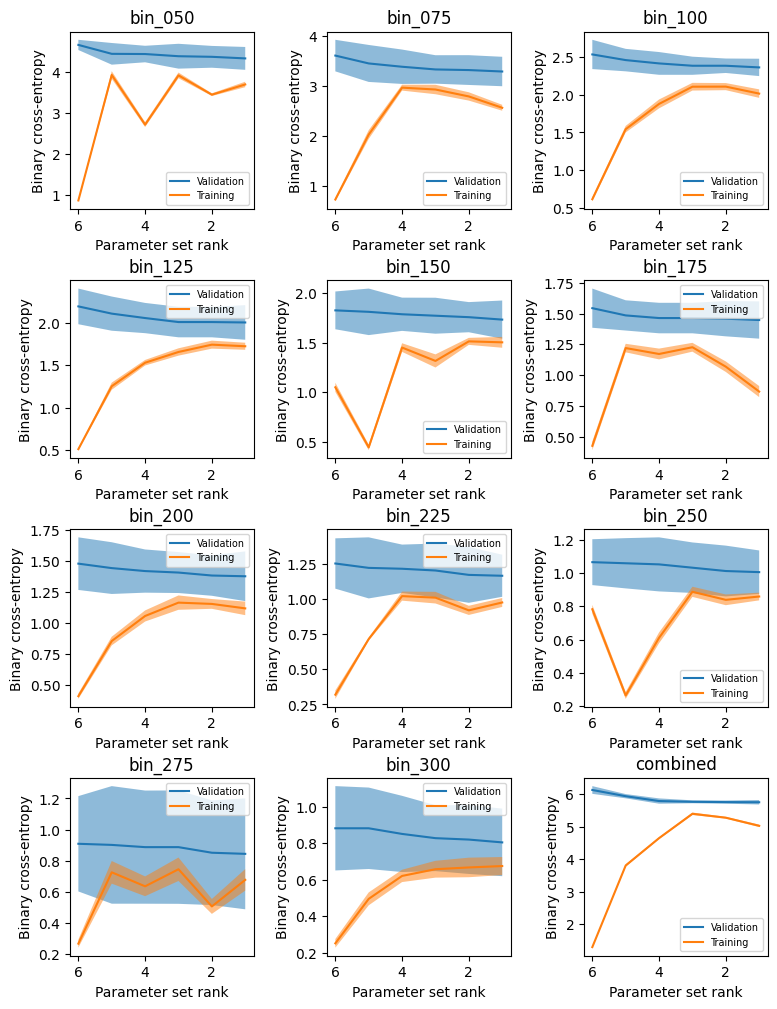

In [10]:
# Plot the results
plot_funcs.plot_hyperparameter_tuning(cv_results).show()

### 3.3. Winning models comparison to baseline

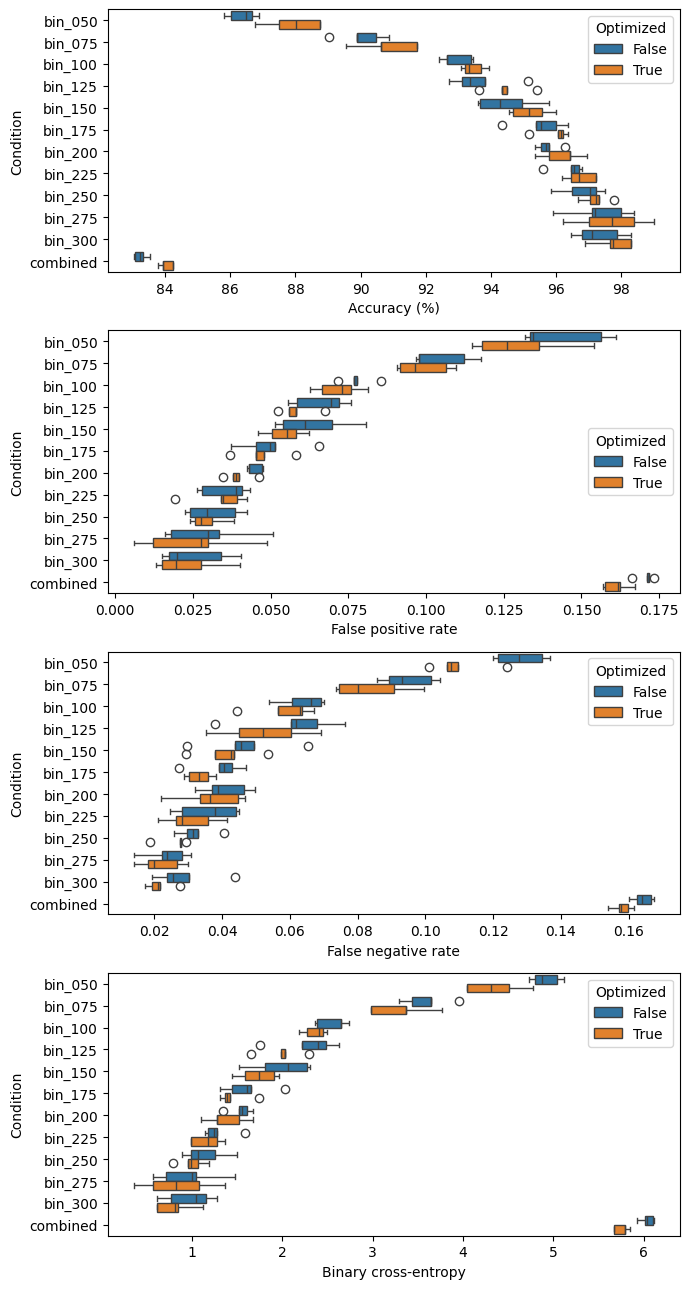

In [11]:
# First we need to go through the hyperparameter optimization results and get
# them formatted so we can add them to the results from the baseline cross-validation
parsed_results = xgb_funcs.add_winners_to_parsed_results(
    cv_results, 
    parsed_results, 
    cv_folds
)

plot_funcs.plot_two_factor_cross_validation(plots, parsed_results).show()

Not bad - hyperparameter optimization gained us a few accuracy percentage points, especially in the short bins where we need it most. We did specify a pretty high-dimensional parameter space, so set's do a bigger, longer run with more iterations overnight tonight.

### 3.4. Winning models evaluation on hold-out test data

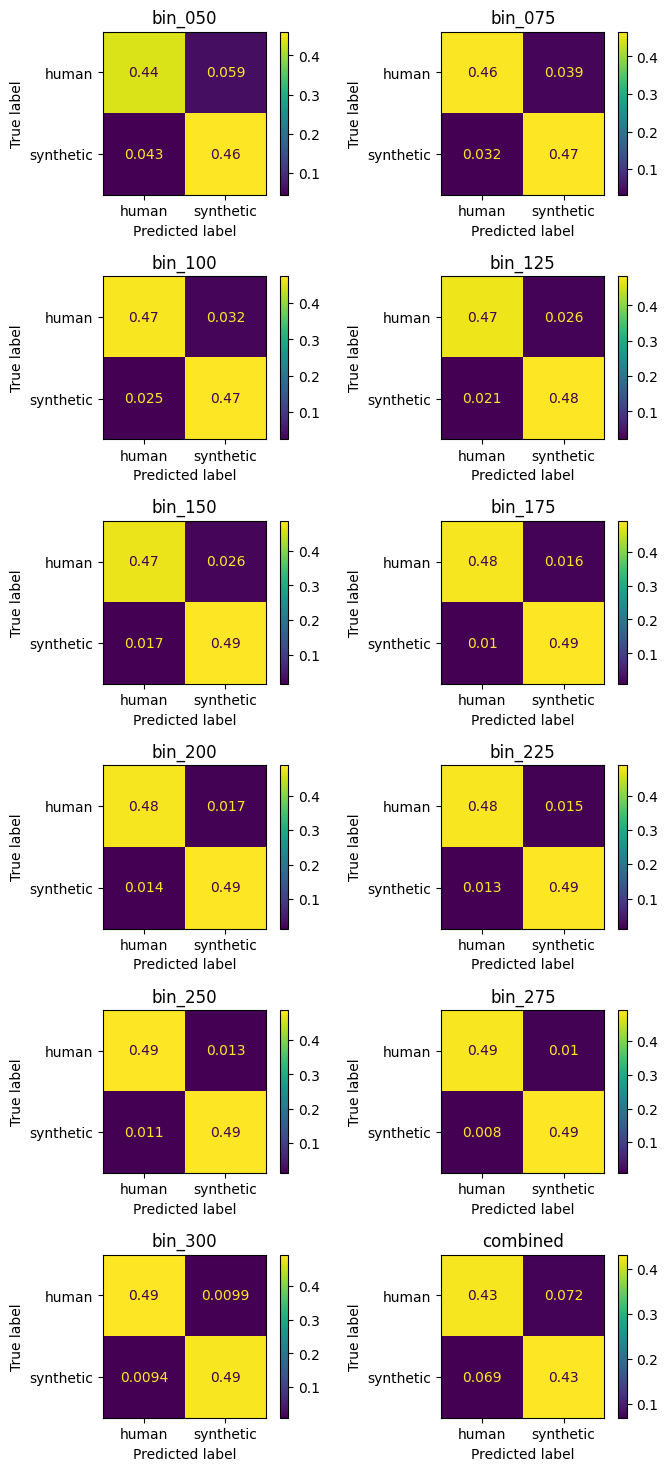

In [12]:
# Plot confusion matrix for hold-out test data in each bin
plot_funcs.plot_testing_confusion_matrices(winners, input_file).show()

Wow, looks great! Performance on the test data is as good as or better than expected from cross-validation. Over fitting is not obviously a concern.

Let's move on to setting up the stage II classifiers. Plan here is as described above - we need to:

1. Add the class probability output from both applicable stage I classifiers to each fragment as a new training feature.
2. Build and train a second set of classifiers that correspond to the bin overlaps and take the original features plus the class probabilities added in step 1.

## 4. Stage I class probabilities feature addition

In [17]:
import h5py
import numpy as np
import pandas as pd

In [19]:
# Load the winning model from hyperparameter optimization for each bin
with open(hyperparameter_optimization_results_filename, 'rb') as result_input_file:
    results = pickle.load(result_input_file)

# Get the numerical bin length ranges from the hdf5 dataset's metadata
data_lake = h5py.File(input_file, 'r')
bins = dict(data_lake.attrs.items())
data_lake.close()

for bin_id, bin_range in bins.items():
    print(f'{bin_id}: {bin_range[0]}-{bin_range[1]}')

# Now, we need to visit each text fragment in the training and testing
# data and score it with both classifiers that it falls into the
# length range of

# Open a connection to the hdf5 dataset via PyTables with Pandas
data_lake = pd.HDFStore(input_file)

# Load the combined training data features
features_df = data_lake[f'training/combined/features']

# Clean up the features for training
features = xgb_funcs.prep_data(
    features_df = features_df, 
    shuffle_control = False
)

# Close the connection
data_lake.close()

def class_probability_scores(fragment: np.ndarray, bins: dict, results: dict) -> tuple[float, float]:
    '''Takes bin dictionary and hyperparameter tuning results.
    Uses best model for each applicable length bin to score
    text fragments.'''

    print(fragment)




bin_050: 1-50
bin_075: 26-75
bin_100: 51-100
bin_125: 76-125
bin_150: 101-150
bin_175: 126-175
bin_200: 151-200
bin_225: 176-225
bin_250: 201-250
bin_275: 226-275
bin_300: 251-300
combined: 0.0-inf
<class 'pandas.core.frame.DataFrame'>
Index: 39042 entries, 0 to 39041
Data columns (total 9 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Fragment length (tokens)                            39042 non-null  int64  
 1   Perplexity                                          39042 non-null  float64
 2   Cross-perplexity                                    39042 non-null  float64
 3   Perplexity ratio score                              39042 non-null  float64
 4   Perplexity ratio score Kullback-Leibler divergence  39042 non-null  float64
 5   Human TF-IDF                                        39042 non-null  float64
 6   Synthetic TF-IDF                              